Fitting 2 folds for each of 20 candidates, totalling 40 fits

Best parameters found: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}

Model Evaluation on Test Set:
Mean Squared Error: 0.3015
Root Mean Squared Error: 0.5491
R² Score: 0.9757

Top 10 assist players from model prediction (1992–2024):
Player
Wayne Rooney       163.029377
Steven Gerrard     153.013162
Frank Lampard      133.440027
Ryan Giggs         132.021300
Kevin De Bruyne    116.200696
David Beckham      100.138611
Cesc Fàbregas       95.604313
Dennis Bergkamp     85.018060
Thierry Henry       77.371980
David Silva         72.713508
Name: Predicted_Assists, dtype: float64


/tmp/ipython-input-2104462836.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_cols)[indices], palette="viridis")


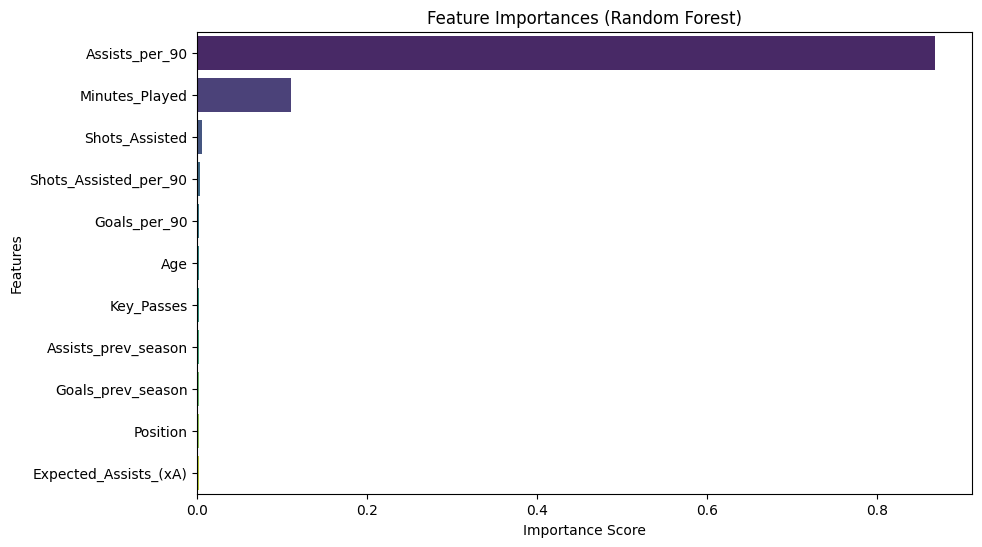

In [4]:
# =========================
# EPL Top Assist Prediction (Fast Version)
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# =========================
# 1. Load Data
# =========================
df = pd.read_csv("/content/topassist.csv")

# Drop unnecessary columns
drop_cols = [
    "Rank", "Club", "Crosses_Completed",
    "Assists_per_90", "xA_per_90", "Key_Passes_per_90",
    "Set_Piece_Involvement", "Club_Total_Goals",
    "Club_League_Rank", "Big6_Club_Feature",
    "Club_Attack_Share", "Club_xG",
    "Dribbles_Completed", "Dribbles_per_90",
    "Contribution_Ratio"
]
df.drop(columns=drop_cols, inplace=True, errors="ignore")

# =========================
# 2. Handle Missing Data
# =========================
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna("Unknown")
df.drop_duplicates(inplace=True)

# =========================
# 3. Feature Engineering
# =========================
df["Assists_per_90"] = df["Assists"] / (df["Minutes_Played"] / 90).replace(0, np.nan)
df["Goals_per_90"] = df["Goals_prev_season"] / (df["Minutes_Played"] / 90).replace(0, np.nan)
df["Shots_Assisted_per_90"] = df["Shots_Assisted"] / (df["Minutes_Played"] / 90).replace(0, np.nan)
df.fillna(0, inplace=True)

le = LabelEncoder()
df["Position"] = le.fit_transform(df["Position"])

# =========================
# 4. Define Features & Target
# =========================
feature_cols = [
    'Age', 'Position', 'Minutes_Played',
    'Assists_prev_season', 'Goals_prev_season',
    'Key_Passes', 'Expected_Assists_(xA)',
    'Shots_Assisted', 'Assists_per_90',
    'Goals_per_90', 'Shots_Assisted_per_90'
]

X = df[feature_cols]
y = df["Assists"]

# =========================
# 5. Train/Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# 6. Random Forest + Randomized Search (Faster)
# =========================
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2,3,4,5],
    'min_samples_leaf': [1,2,3],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,          # Reduced iterations
    cv=2,               # Reduced CV folds
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='r2'
)

random_search.fit(X_train, y_train)
best_rf_model = random_search.best_estimator_
print("\nBest parameters found:", random_search.best_params_)

# =========================
# 7. Evaluation
# =========================
y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation on Test Set:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# =========================
# 8. Historical Predictions
# =========================
filtered_df = df[
    (df['Season'].str.slice(0,4).astype(int) >= 1992) &
    (df['Season'].str.slice(0,4).astype(int) <= 2024)
].copy()
filtered_df.fillna(0, inplace=True)
X_filtered = filtered_df[feature_cols]
filtered_df['Predicted_Assists'] = best_rf_model.predict(X_filtered)

top_players = filtered_df.groupby('Player')['Predicted_Assists'].sum().sort_values(ascending=False)
print("\nTop 10 assist players from model prediction (1992–2024):")
print(top_players.head(10))

# =========================
# 9. Feature Importance Plot
# =========================
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=np.array(feature_cols)[indices], palette="viridis")
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()
